### Import Packages

In [1]:
! nvidia-smi

Fri May  2 18:48:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          Off |   00000000:25:00.0 Off |                    0 |
| N/A   28C    P0             33W /  250W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy import stats

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, MultiHeadAttention, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print("TensorFlow version: ", tf.__version__)
print("Number of GPUs available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version:  2.19.0
Number of GPUs available:  1


### Data Preprocessing

In [3]:
wind_cols = ['uSq','e_uSq','n_uSq','Z2','Z3','Z4']
scaled_wind_cols = ['scaled_' + col for col in wind_cols]

# Load datasets
df1 = pd.read_csv('Data_2004_2013.csv')

# Set the timestamp column as the index
df1['TimeStamp_1'] = pd.to_datetime(df1['TimeStamp_1'], format='mixed')
df1.set_index('TimeStamp_1', inplace=True)

# Train-Test split
# df_train: [2004-11-01 00:00:00 ~ 2007-10-31 23:00:00, 2008-11-01 00:00:00 ~ 2013-10-31 23:00:00]
# df_test: [2007-11-01 00:00:00 ~ 2008-10-31 23:00:00]
split1 = pd.to_datetime('2007-10-31 23:59:00')
split2 = pd.to_datetime('2008-10-31 23:59:00')
df_train = df1[(df1.index < split1) | (df1.index > split2)]
df_test = df1[(df1.index > split1) & (df1.index < split2)]

# Data normalization
scaled_wave = MinMaxScaler()
scaled_wave = scaled_wave.fit(df_train[['H']])

### Data Preparation: Train-Test-Validation Split

In [4]:
time_step = 6
features = ['scaled_H'] + scaled_wind_cols

def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data)-time_step):
        X.append(data[i:(i+time_step+1), 1:])  # Past hours wind features
        y.append(data[i+time_step, 0])         # Current hour wave height
    return np.array(X), np.array(y)

# Training set: [2004-11-01 00:00:00 ~ 2007-10-31 23:00:00, 2009-11-01 00:00:00 ~ 2013-10-31 23:00:00]
# Validation set: [2008-11-01 00:00:00 ~ 2009-10-31 23:00:00]
split3 = pd.to_datetime('2009-10-31 23:59:00')
df_train1 = df_train[df_train.index < split1]
df_train2 = df_train[df_train.index > split3]
df_val = df_train[(df_train.index > split2) & (df_train.index < split3)]

X_train1, y_train1 = create_sequences(df_train1[features].values, time_step)
X_train2, y_train2 = create_sequences(df_train2[features].values, time_step)
X_train, y_train = np.concatenate((X_train1, X_train2), axis=0), np.concatenate((y_train1, y_train2), axis=0)
X_val, y_val = create_sequences(df_val[features].values, time_step)
X_test, y_test = create_sequences(df_test[features].values, time_step)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(61332, 7, 6)
(8754, 7, 6)
(8778, 7, 6)


### Model Selection and Implementation

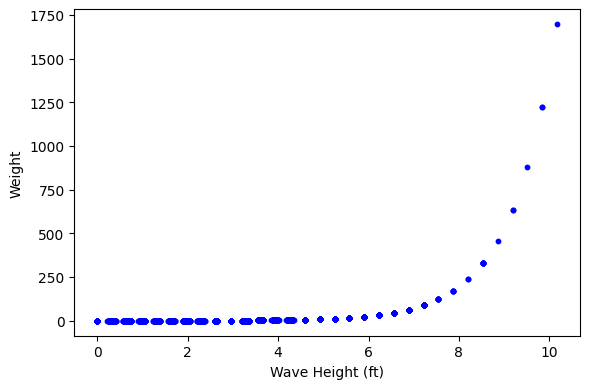

In [5]:
y_rescaled = scaled_wave.inverse_transform(y_train.reshape(-1, 1))
weights = np.exp(y_rescaled.flatten())
weights = weights / np.mean(weights)

plt.figure(figsize=(6, 4))
plt.scatter(y_rescaled, weights, s=10.0, color='b')
plt.xlabel('Wave Height (ft)')
plt.ylabel('Weight')

plt.tight_layout()
plt.show()

In [6]:
epochs = 100
batch_size = 64
model_file = 'best_model_reg1.keras'

def create_model(X_train):
    # Input layer with shape: (batch_size, time_steps, features)
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    # LSTM layer
    units = 128
    lstm_layer = LSTM(units=64, activation='tanh', return_sequences=True)(input_layer)
    lstm_out = LSTM(units=units, activation='tanh', return_sequences=True)(lstm_layer)
    
    # Attention layer
    num_heads = 2
    attn_layer = MultiHeadAttention(num_heads=num_heads, key_dim=units//num_heads)
    attn_out, attn_scores = attn_layer(lstm_out, lstm_out, return_attention_scores=True)

    # Pooling layer
    pooled_out = GlobalAveragePooling1D()(attn_out)

    # Output layer
    output_layer = Dense(1, activation='relu')(pooled_out)

    # Build model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mse'])
    attn_model = Model(inputs=input_layer, outputs=attn_scores)
    
    return model, attn_model

# Train and save the model (architecture + weights)
model, attn_model = create_model(X_train)

I0000 00:00:1752609868.805987 3799907 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37123 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:25:00.0, compute capability: 8.0


I0000 00:00:1752609889.462063 3800123 cuda_dnn.cc:529] Loaded cuDNN version 90300


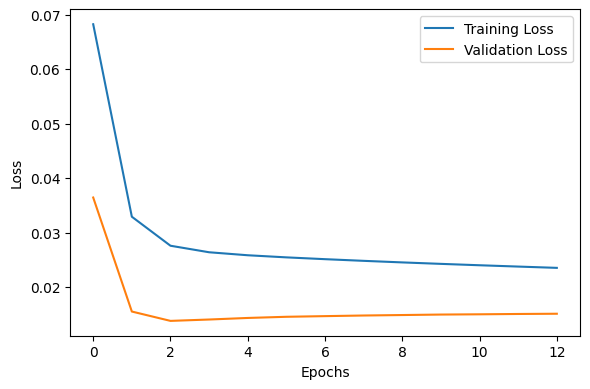

In [7]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, sample_weight=weights, validation_data=(X_val, y_val), callbacks=[es], verbose=0)
model.save(model_file)

# Plot the training & validation loss over epochs
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

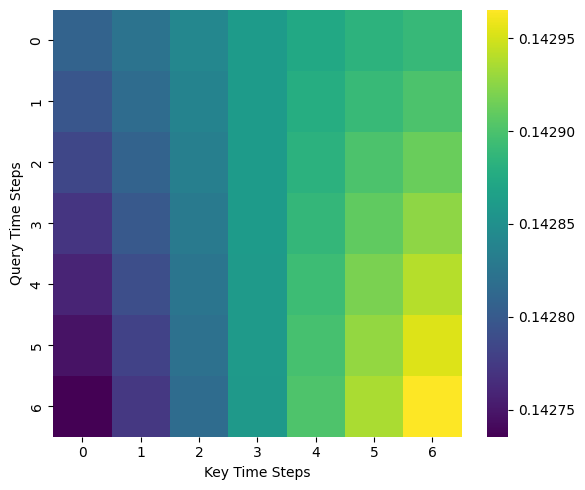

In [8]:
head_idx = 0
attn_weights = attn_model.predict(X_test, verbose=0)
attn_head_matrix = attn_weights[:, head_idx, :, :]
attn_matrix = np.mean(attn_head_matrix, axis=0)

plt.figure(figsize=(6, 5))
sns.heatmap(attn_matrix, cmap='viridis')
plt.xlabel("Key Time Steps")
plt.ylabel("Query Time Steps")

plt.tight_layout()
plt.show()

### Model Evaluation

In [9]:
# Load the saved model
model = load_model(model_file)

# Training error
y_pred1 = model.predict(X_train, verbose=0)
y_pred1_raw = scaled_wave.inverse_transform(y_pred1)
y_true1 = pd.concat([df_train1['H'][time_step:], df_train2['H'][time_step:]], axis=0)
print(f'Training RMSE: {np.sqrt(mean_squared_error(y_true1, y_pred1_raw)):.3f}')

# Validation error
y_pred2 = model.predict(X_val, verbose=0)
y_pred2_raw = scaled_wave.inverse_transform(y_pred2)
y_true2 = df_val['H'][time_step:]
print(f'Validation RMSE: {np.sqrt(mean_squared_error(y_true2, y_pred2_raw)):.3f}')

# Test error
y_pred3 = model.predict(X_test, verbose=0)
y_pred3_raw = scaled_wave.inverse_transform(y_pred3)
y_true3 = df_test['H'][time_step:]
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_true3, y_pred3_raw)):.3f}')

Training RMSE: 1.312
Validation RMSE: 1.194
Test RMSE: 1.221


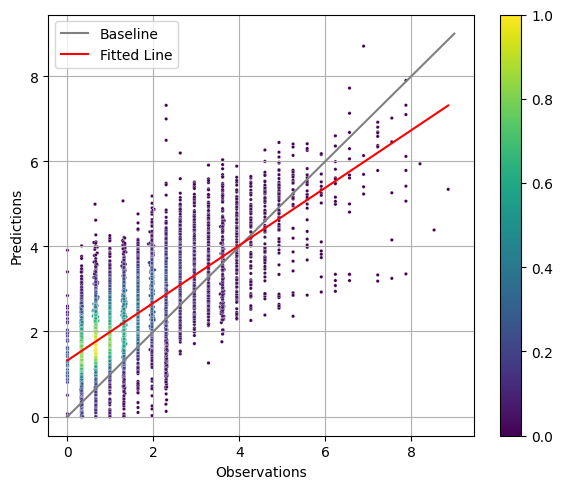

In [10]:
def pred_vs_obs(y_true, y_pred):
    y_pred = y_pred.flatten()
    fig, ax = plt.subplots(figsize=(6, 5))
    
    ax.plot([0, 9], [0, 9], color='grey', label='Baseline')
    ax.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true,y_pred,1))(np.unique(y_true)), color='r', label='Fitted Line')
    ax.set(xlabel='Observations', ylabel='Predictions')
    ax.legend()
    ax.grid()
    
    kernel = stats.gaussian_kde(np.vstack([y_true, y_pred]))(np.vstack([y_true, y_pred]))
    sns.scatterplot(x=y_true, y=y_pred, c=kernel, s=6, cmap='viridis', ax=ax)
    fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=ax)
    
    plt.tight_layout()
    plt.show()

pred_vs_obs(y_true3, y_pred3_raw)

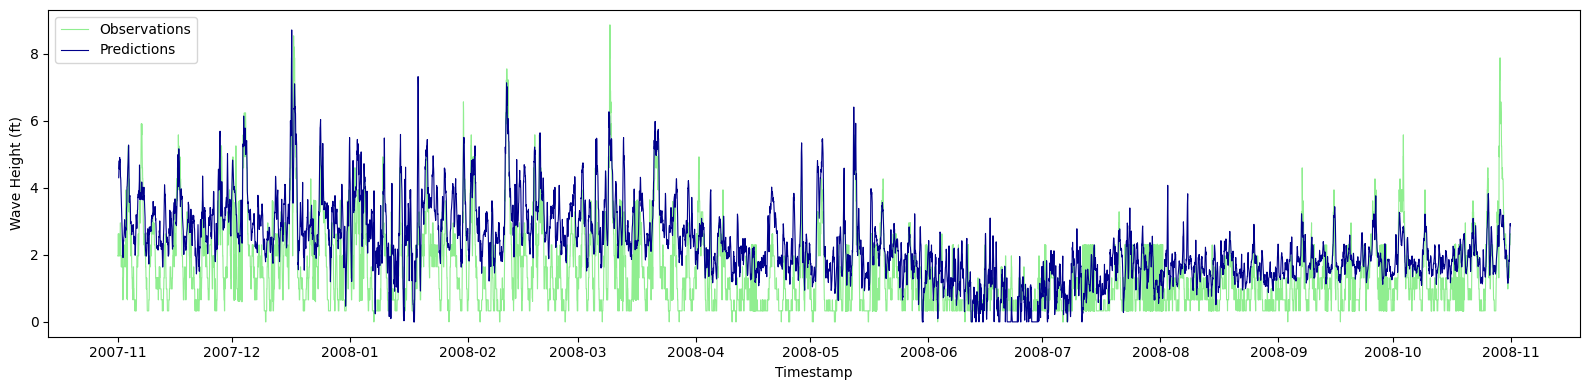

In [11]:
plt.figure(figsize=(16, 4))
plt.plot(df_test.index, df_test['H'], linewidth=0.8, color='lightgreen', label='Observations')
plt.plot(df_test.index[time_step:], y_pred3_raw, linewidth=0.8, color='darkblue', label='Predictions')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlabel('Timestamp')
plt.ylabel('Wave Height (ft)')
plt.legend()

plt.tight_layout()
plt.show()

### Model Output

In [ ]:
# Create sequences for the full dataset
X, _ = create_sequences(df1[features].values, time_step)

# Add predicted wave heights
df1['H_pred1'] = 0.0
df1.loc[df1.index[time_step:], 'H_pred1'] = model.predict(X, verbose=0).flatten()
df1.to_csv('Data_2004_2013.csv')

df1.head(10)

,H,uSq,e_uSq,n_uSq,Z2,Z3,Z4,scaled_H,scaled_uSq,scaled_e_uSq,scaled_n_uSq,scaled_Z2,scaled_Z3,scaled_Z4,H_pred0,Spike,Spike_prob,Spike_pred,H_pred1
TimeStamp_1,,,,,,,,,,,,,,,,,,,
2004-11-01 00:00:00,3.249133,19.225945,18.733185,-4.324897,556.247086,16093.4,465615.964363,0.319463,0.042443,0.717843,0.427481,0.101141,0.042553,0.021635,0.000000,0,0.000000,0.0,0.000000
2004-11-01 01:00:00,3.249133,47.299731,-43.539632,18.481477,872.475497,16093.4,296853.635864,0.319463,0.111609,0.612923,0.482862,0.181946,0.042553,0.012009,0.000000,0,0.000000,0.0,0.000000
2004-11-01 02:00:00,1.960359,43.096993,-23.472305,-36.144180,832.812792,16093.4,310991.288972,0.192748,0.101255,0.646733,0.350213,0.171811,0.042553,0.012816,0.000000,0,0.000000,0.0,0.000000
2004-11-01 03:00:00,2.001249,28.241040,-25.162951,-12.821164,674.161969,16093.4,384177.000917,0.196768,0.064654,0.643885,0.406849,0.131272,0.042553,0.016990,0.000000,0,0.000000,0.0,0.000000
2004-11-01 04:00:00,3.254957,35.278017,-19.213785,-29.586634,753.487381,16093.4,343731.733585,0.320036,0.081991,0.653908,0.366137,0.151541,0.042553,0.014683,0.000000,0,0.000000,0.0,0.000000
2004-11-01 05:00:00,3.298333,33.337921,-13.026164,-30.687718,732.475598,16093.4,353592.016416,0.324301,0.077211,0.664333,0.363463,0.146172,0.042553,0.015245,0.000000,0,0.000000,0.0,0.000000
2004-11-01 06:00:00,0.298153,67.513173,56.621311,-36.770309,1042.361020,16093.4,248471.996288,0.029315,0.161410,0.781679,0.348693,0.225356,0.042553,0.009250,0.168065,0,0.204404,0.0,0.255093
2004-11-01 07:00:00,0.329992,43.711596,31.968638,-29.811237,838.730115,16093.4,308797.214744,0.032446,0.102769,0.740143,0.365591,0.173323,0.042553,0.012690,0.184581,0,0.331286,1.0,0.283880
2004-11-01 08:00:00,0.307853,55.203975,40.373631,-37.649020,942.560154,16093.4,274780.895794,0.030269,0.131084,0.754304,0.346559,0.199855,0.042553,0.010750,0.174609,0,0.411070,1.0,0.275175
